In [1]:
from numpy import random as rd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

from tqdm import tqdm

# Gerar sinais

Aviso: cosseno não validado!


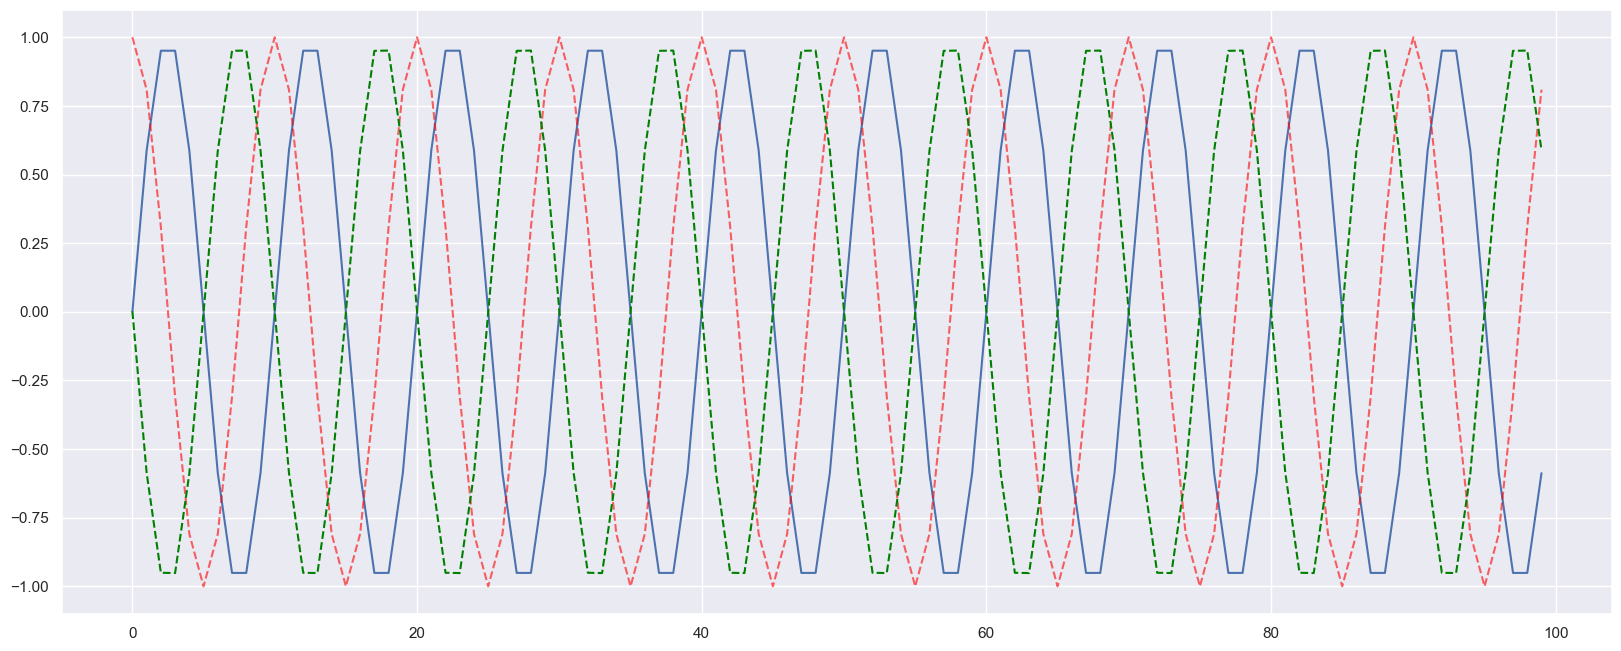

In [2]:
from metodos.geraSenoide import geraSenoide
from metodos.getFreq import getFreq

N = int(1e3) 
f0 = 100
fs = 1000
x = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs)
y = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs, cosseno=1)
z = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs, theta0=3.14)
p = sns.lineplot(data = x[0:100])
p = sns.lineplot(data = y[0:100], color = 'red', linestyle = '--', alpha= 0.6)
p = sns.lineplot(data = z[0:100], color = 'green', linestyle = '--')
p.grid(True)

# LFT

In [3]:
from metodos.LFT import vcLFT, ordLFT

## Espectro

100
(Detecções no ruído 1) FP: 0.0
(Detecções no ruído 2) FP: 0.0
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


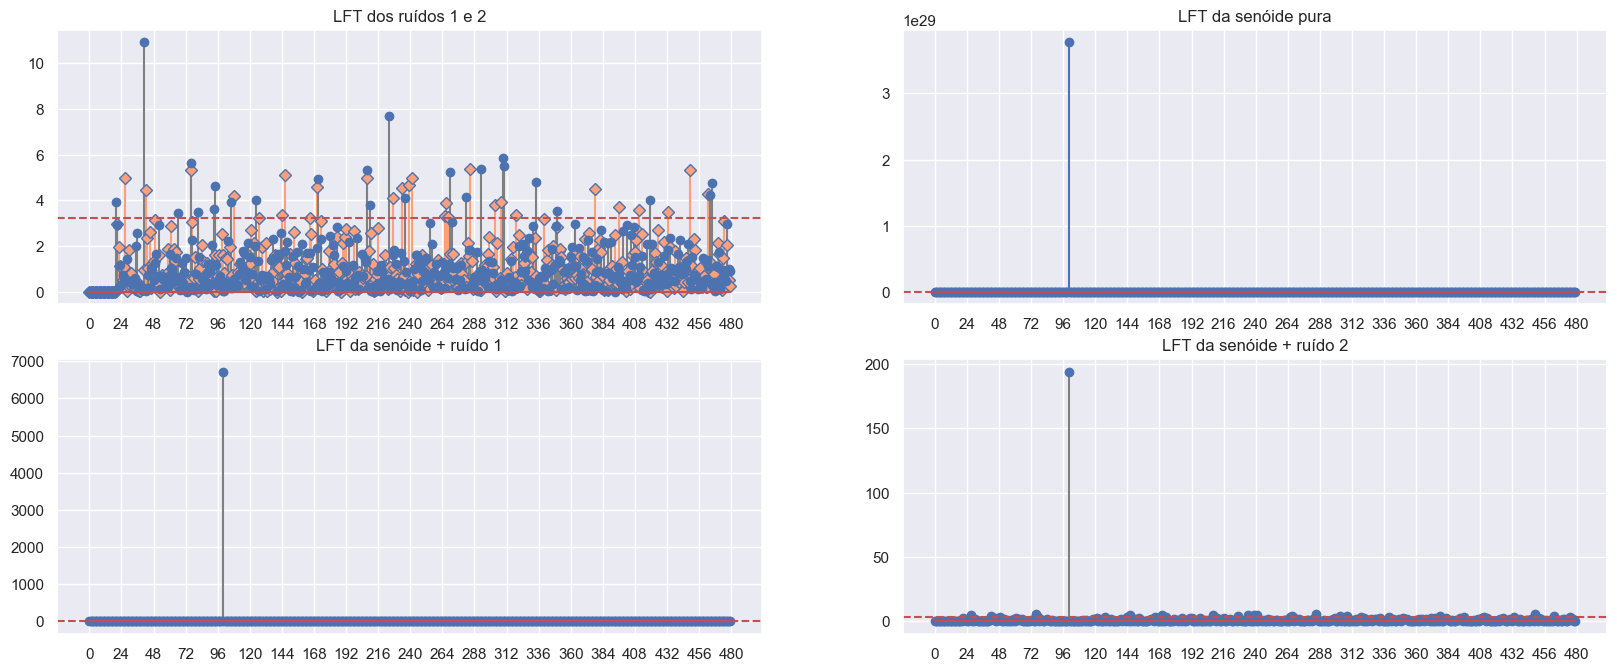

In [4]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
N = round(1e3)
L = 20

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N) + 10
sinal = geraSenoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, _, _] = getFreq(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]
print(bin_f0)
limiar = vcLFT(L=L, alpha=0.05)

# Calcula CSM:
o1 = np.zeros((round(N/2 - L)))
o2 = np.zeros((round(N/2 - L)))
o3 = np.zeros((round(N/2 - L)))
o4 = np.zeros((round(N/2 - L)))
o5 = np.zeros((round(N/2 - L)))

for ff in range(L,round(N/2)-L):
    [_,o1[ff]] = ordLFT(sinal=ruido1, L=L, BIN=ff)
    [_,o2[ff]] = ordLFT(sinal=ruido2, L=L, BIN=ff)
    [_,o3[ff]] = ordLFT(sinal=sinal, L=L, BIN=ff)
    [_,o4[ff]] = ordLFT(sinal=sinal+ruido1, L=L, BIN=ff)
    [_,o5[ff]] = ordLFT(sinal=sinal+ruido2, L=L, BIN=ff)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('LFT dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('LFT da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o5)/20));
plt.title('LFT da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('LFT da senóide + ruído 2');

print('(Detecções no ruído 1) FP:',np.sum(np.where(o1[bin_f0]>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2[bin_f0]>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

## Monte-Carlo Singleshot

Simulando: 100%|██████████| 10000/10000 [00:00<00:00, 11185.73it/s]


Probabilidade de detecção atingida: 94.17%
(PD esperada =  95.0%)
Detectou?  True


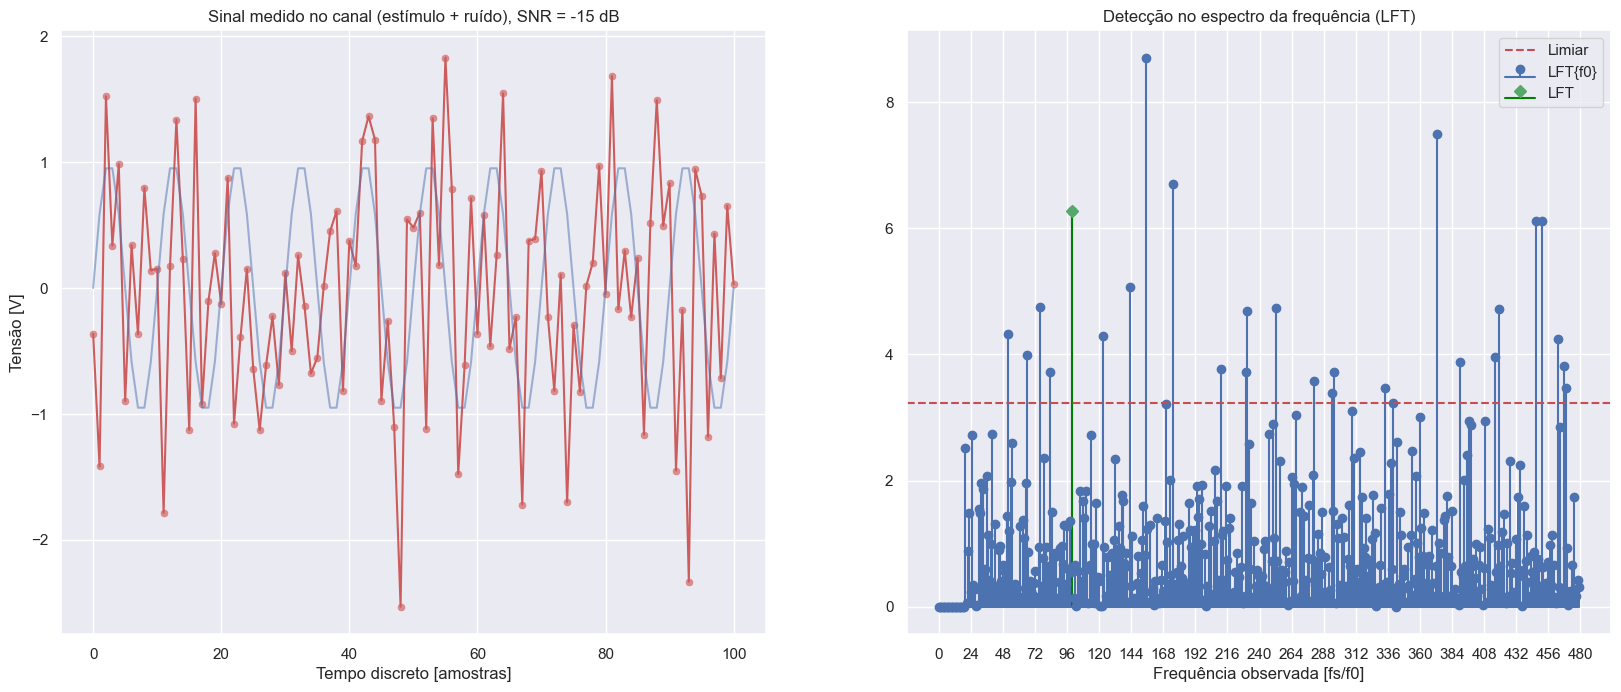

In [5]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)
N = int(1e3) # num. de pontos na senóide

# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
x = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs)
L = 20
bin_f0 = round(len(x)*f0/fs)

mediaRuido = 0
energia_ruido = 1
SNRi = -15

limiar = vcLFT(L=L) # alpha = 5% (default)
nd = 0
ORD = np.zeros((round(N/2)-L,))


for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    ruido = mediaRuido + energia_ruido*rd.randn(N,)
    A = 10**(SNRi/20)*(energia_ruido**2);
    sinal = A*x + ruido
    
    if i == nSim-1:
        for ff in range(L,round(N/2)-L):
            [_, ORD[ff]]= ordLFT(sinal=sinal, L=L, BIN=ff)

    [_, o]= ordLFT(sinal=sinal, L=L, BIN=bin_f0)
    # Detecção?
    if o > limiar: nd +=1

alpha = 0.05
print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
# LFT(f):
plt.stem(ORD, linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')

# LIMIAR:
plt.axhline(y=limiar, color='r', linestyle = '--');

# Estilo:
plt.title('Detecção no espectro da frequência (LFT)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)+len(ORD)/20), len(ORD)/20))
plt.legend(['Limiar','LFT{f0}','LFT'])

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)


# CSM 

In [6]:
from metodos.CSM import vcCSM, ordCSM

## Espectro

(Detecções no ruído 1) FP: 2.0
(Detecções no ruído 2) FP: 2.3
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


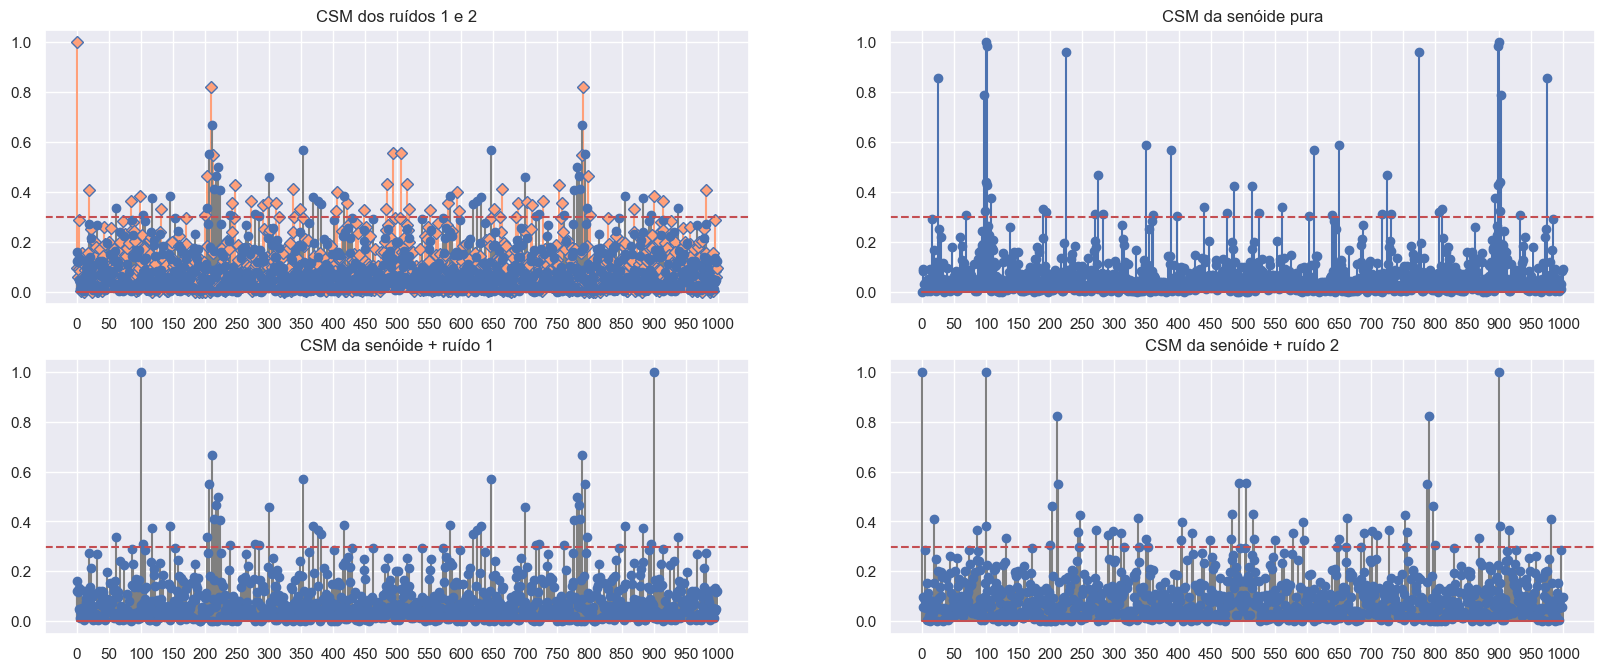

In [7]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = geraSenoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, _, _] = getFreq(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]
limiar = vcCSM(M=M, alpha=0.05)

# Calcula CSM:
[_,o1] = ordCSM(sinal=ruido1, tamanhoJanela=tj, M=M)
[_,o2] =ordCSM(sinal=ruido2, tamanhoJanela=tj, M=M)
[_,o3] =ordCSM(sinal=sinal, tamanhoJanela=tj, M=M)
[_,o4] =ordCSM(sinal=sinal+ruido1, tamanhoJanela=tj, M=M)
[_,o5] =ordCSM(sinal=sinal+ruido2, tamanhoJanela=tj, M=M)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('CSM dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('CSM da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 2');

tamanhoSinal = len(o3)
bin_f0 = round(f0*tamanhoSinal/fs)
print('(Detecções no ruído 1) FP:',np.sum(np.where(o1>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

## Monte-Carlo Singleshot

Simulando: 100%|██████████| 10000/10000 [00:34<00:00, 291.02it/s]


Probabilidade de detecção atingida: 88.08%
(PD esperada =  95.0%)
Detectou?  True


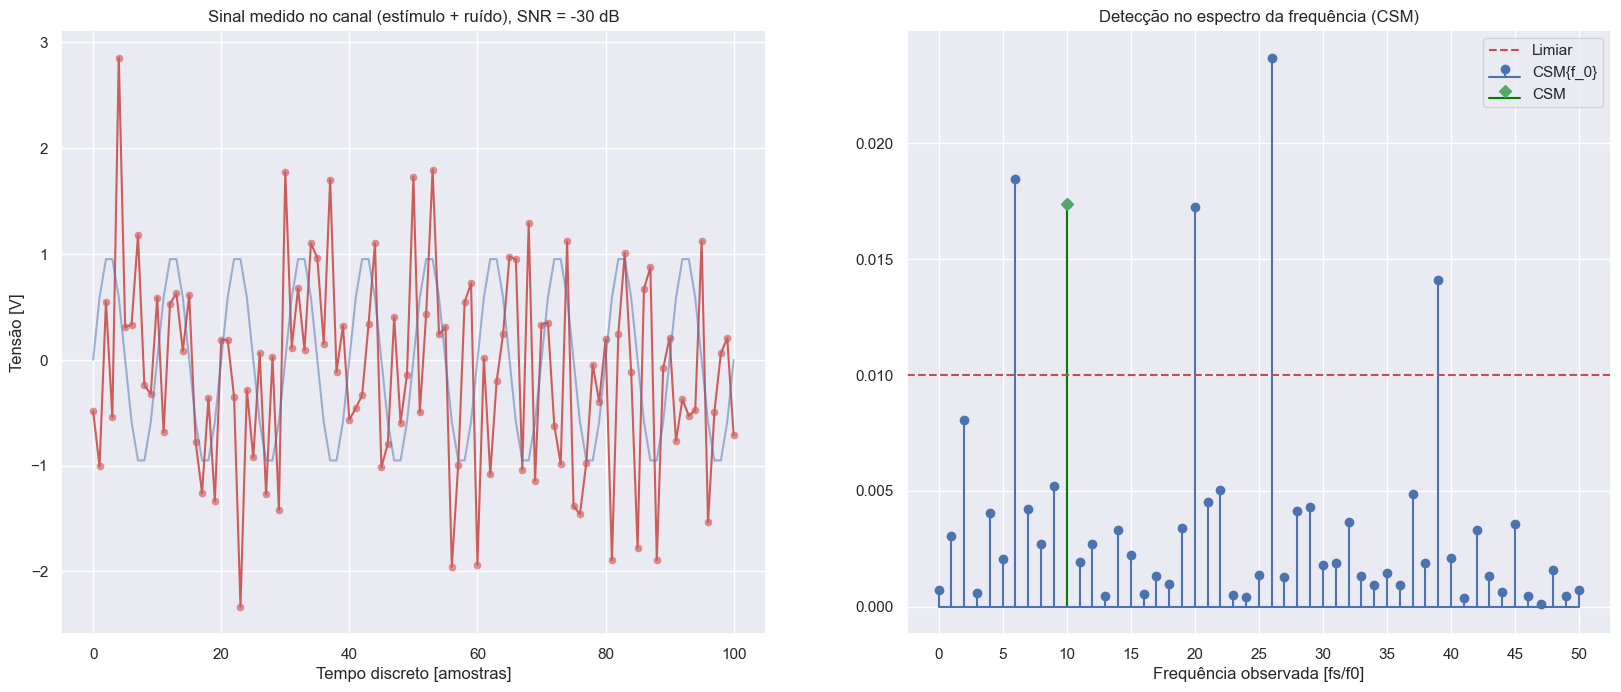

In [8]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs)

amplitudeRuido = 0
energia_ruido = 1
SNRi = -30
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vcCSM(M=M) # alpha = 5%
nd  = 0

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    A = 10**(SNRi/20)*(energia_ruido**2);
    ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
    sinal = A*x  + ruido
    
    # Calcula SFT na f0:
    [_, ORD]= ordCSM(sinal = sinal, tamanhoJanela=tj, M= M)

    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1


print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig2 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (CSM)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['Limiar','CSM{f_0}','CSM'])

# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)

# MSC

In [9]:
from metodos.MSC import vcMSC, ordMSC

## Espectro

(Detecções no ruído 1) FP: 1.8
(Detecções no ruído 2) FP: 2.8
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


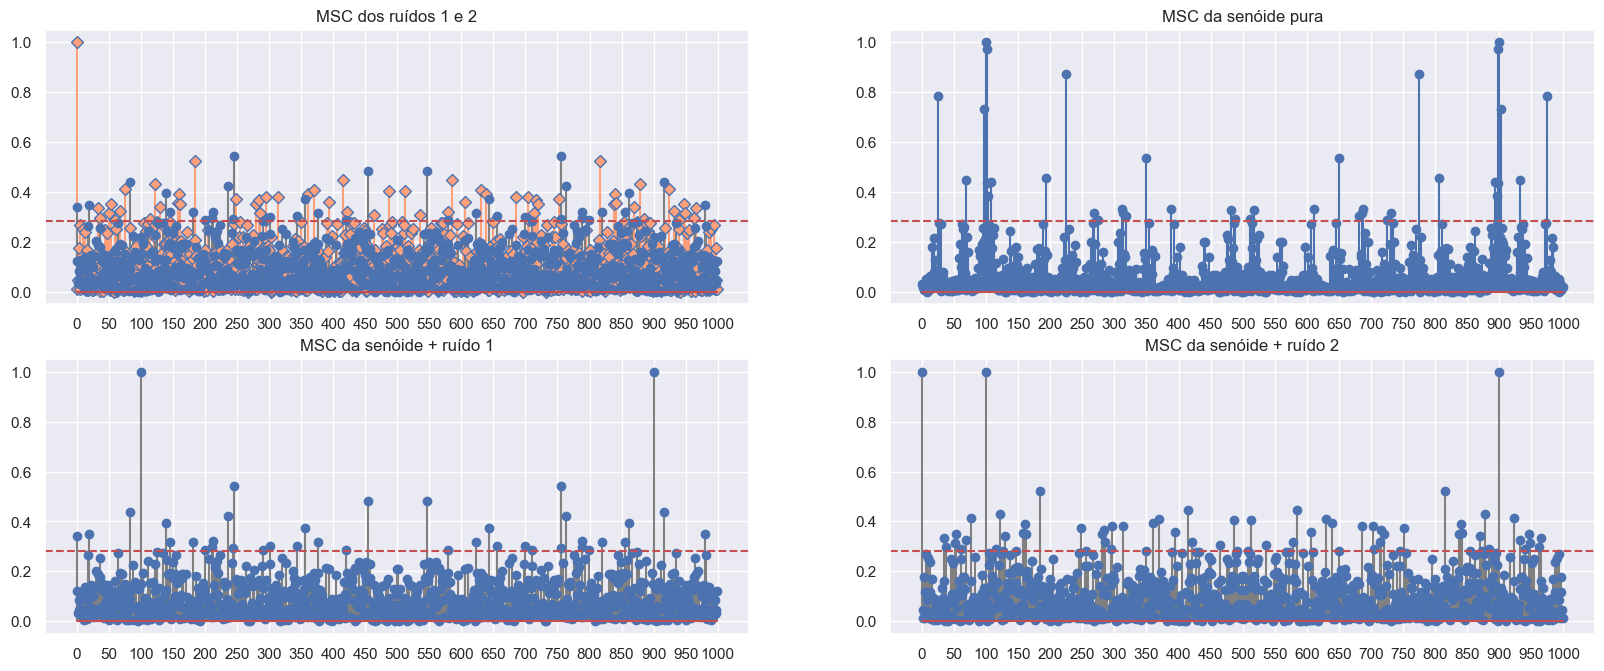

In [10]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = geraSenoide(amplitude=5, N=N, f0 = f0, fs=fs)
bin_f0 = round(len(sinal)*f0/fs)
limiar = vcMSC(M=M, alpha=0.05)

# Calcula CSM:
[_,o1] = ordMSC(sinal=ruido1, tamanhoJanela=tj, M=M)
[_,o2] =ordMSC(sinal=ruido2, tamanhoJanela=tj, M=M)
[_,o3] =ordMSC(sinal=sinal, tamanhoJanela=tj, M=M)
[_,o4] =ordMSC(sinal=sinal+ruido1, tamanhoJanela=tj, M=M)
[_,o5] =ordMSC(sinal=sinal+ruido2, tamanhoJanela=tj, M=M)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('MSC dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('MSC da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o4)/20));
plt.title('MSC da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('MSC da senóide + ruído 2');

# Algumas informações:
tamanhoSinal = len(o3)
bin_f0 = round(f0*tamanhoSinal/fs)
print('(Detecções no ruído 1) FP:',np.sum(np.where(o1>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))

## Monte-Carlo Singleshot

Simulando: 100%|██████████| 10000/10000 [00:14<00:00, 696.91it/s]


Probabilidade de detecção atingida: 94.22%
(PD esperada =  95.0%)
Detectou?  True


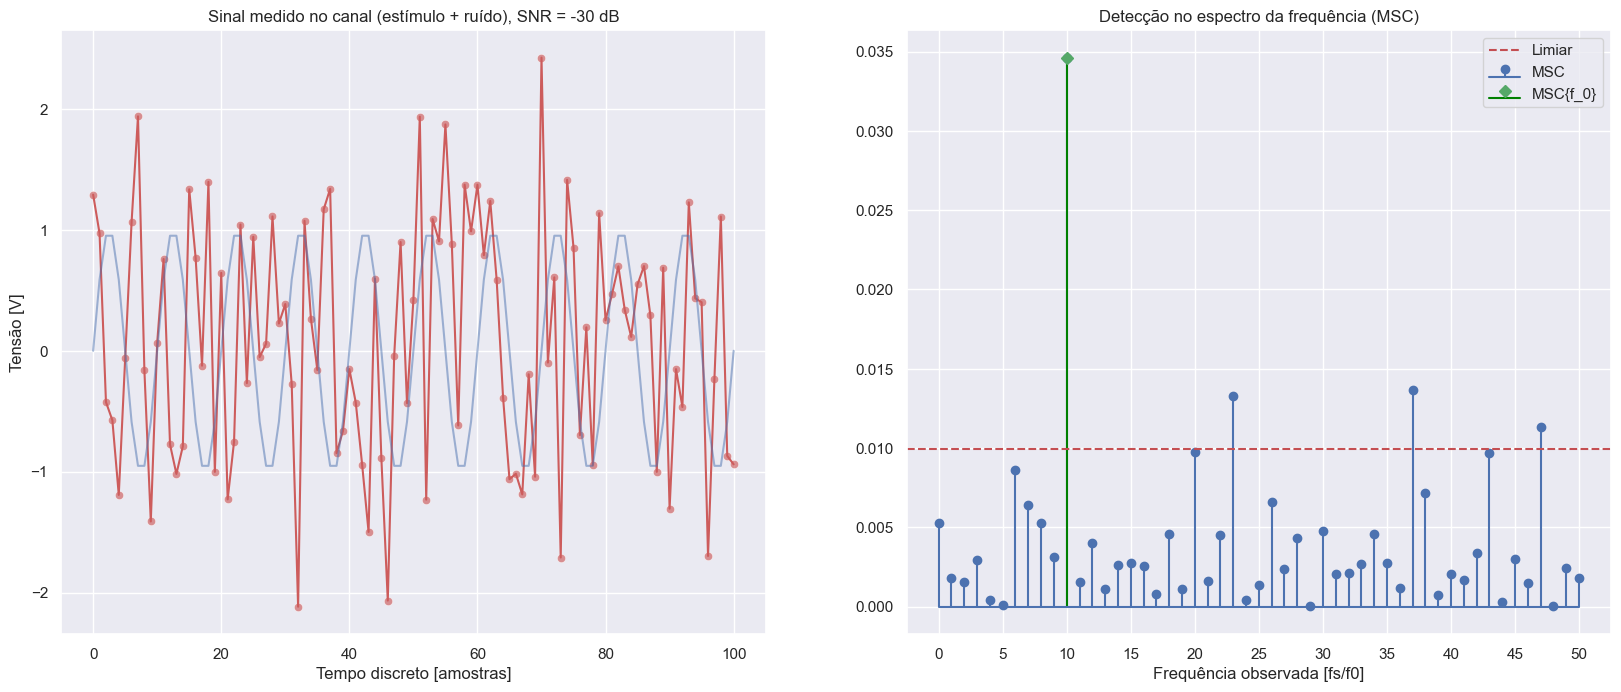

In [13]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs)

amplitudeRuido = 0
energia_ruido = 1
SNRi = -30
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vcMSC(M=M) # alpha = 5%
nd  = 0

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    ruido = energia_ruido*rd.randn(N,) + amplitudeRuido
    sinal = A*x + ruido
    
    
    # Calcula MSC:
    [_, ORD]= ordMSC(sinal = sinal, tamanhoJanela=tj, M= M)

    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1

print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig3 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (MSC)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['Limiar','MSC','MSC{f_0}'])
# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)